In [12]:
!pip install keras 

In [13]:
!pip install tensorflow

In [14]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11)
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import backend as K

In [15]:
folder_benign_train = r'C:\Users\shadm\Desktop\Project\Biomedical_Image_Processing_using_Deep_Learning\images_dataset\train\benign'
folder_malignant_train = r'C:\Users\shadm\Desktop\Project\Biomedical_Image_Processing_using_Deep_Learning\images_dataset\train\maligant'

folder_benign_test = r'C:\Users\shadm\Desktop\Project\Biomedical_Image_Processing_using_Deep_Learning\images_dataset\test\benign'
folder_malignant_test = r'C:\Users\shadm\Desktop\Project\Biomedical_Image_Processing_using_Deep_Learning\images_dataset\test\maligant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

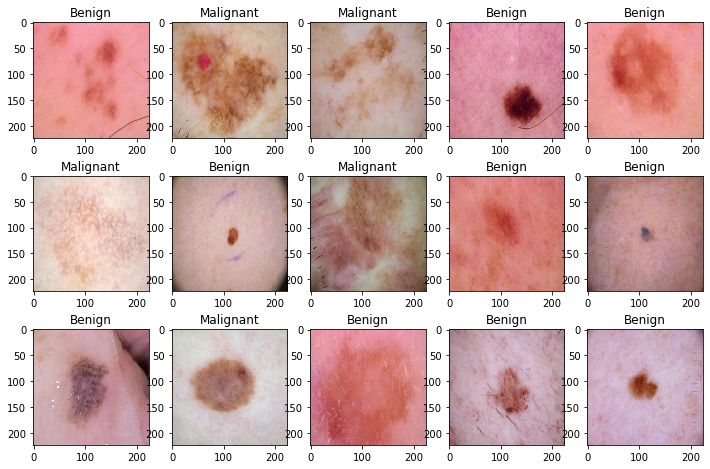

In [16]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [17]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [18]:
X_train = X_train/255.
X_test = X_test/255.

In [19]:
def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [20]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 40
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 56, 56, 64)       

In [21]:
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

Epoch 1/40
3/3 [==============================] - 19s 6s/step - loss: 1.2502 - accuracy: 0.5312 - val_loss: 0.7285 - val_accuracy: 0.5250 - lr: 1.0000e-05
Epoch 2/40
3/3 [==============================] - 16s 5s/step - loss: 1.0799 - accuracy: 0.5063 - val_loss: 0.7692 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 3/40
3/3 [==============================] - 16s 5s/step - loss: 1.0633 - accuracy: 0.5125 - val_loss: 0.7041 - val_accuracy: 0.5250 - lr: 1.0000e-05
Epoch 4/40
3/3 [==============================] - 16s 5s/step - loss: 1.0985 - accuracy: 0.4812 - val_loss: 0.7002 - val_accuracy: 0.5500 - lr: 1.0000e-05
Epoch 5/40
3/3 [==============================] - 16s 5s/step - loss: 0.9788 - accuracy: 0.5188 - val_loss: 0.7283 - val_accuracy: 0.5750 - lr: 1.0000e-05
Epoch 6/40
3/3 [==============================] - 16s 5s/step - loss: 0.9588 - accuracy: 0.5500 - val_loss: 0.6782 - val_accuracy: 0.5750 - lr: 1.0000e-05
Epoch 7/40
3/3 [==============================] - 16s 5s/step - loss: 

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


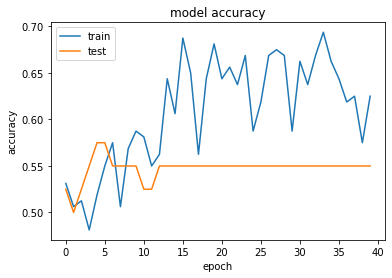

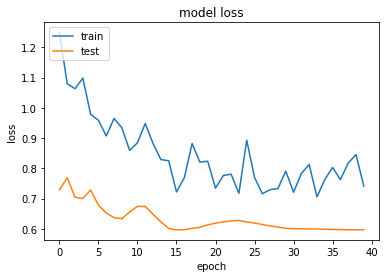

In [22]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
K.clear_session()
del model
del history

In [13]:
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(X_train, y_train):
    model = build(lr=lr, 
                  init= init, 
                  activ= activ, 
                  optim=optim, 
                  input_shape= input_shape)
    
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=1)
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

In [14]:
model = build(lr=lr, 
              init= init, 
              activ= activ, 
              optim=optim, 
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=1,
          callbacks=[learning_rate_reduction]
         )

y_predict = model.predict_classes(X_test)

print(accuracy_score(np.argmax(y_test, axis=1),y_predict))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [15]:
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model.h5")
print("Saved model to disk")

del model
K.clear_session()

Saved model to disk


Epoch 1/40
3/3 [==============================] - 94s 24s/step - loss: 0.9710 - accuracy: 0.4938 - val_loss: 0.6926 - val_accuracy: 0.5250 - lr: 1.0000e-05
Epoch 2/40
3/3 [==============================] - 72s 22s/step - loss: 0.8450 - accuracy: 0.4938 - val_loss: 0.6919 - val_accuracy: 0.5250 - lr: 1.0000e-05
Epoch 3/40
3/3 [==============================] - 71s 22s/step - loss: 0.7796 - accuracy: 0.5125 - val_loss: 0.6921 - val_accuracy: 0.5250 - lr: 1.0000e-05
Epoch 4/40
3/3 [==============================] - 72s 23s/step - loss: 0.7034 - accuracy: 0.5312 - val_loss: 0.6921 - val_accuracy: 0.5250 - lr: 1.0000e-05
Epoch 5/40
3/3 [==============================] - 72s 23s/step - loss: 0.6479 - accuracy: 0.5562 - val_loss: 0.6922 - val_accuracy: 0.5250 - lr: 1.0000e-05
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.5857 - accuracy: 0.6687 
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
3/3 [==============================] - 71s 22s/step

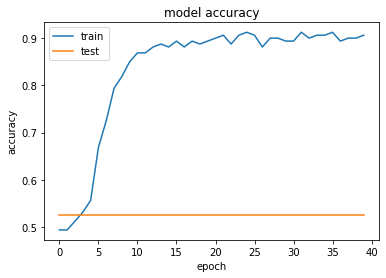

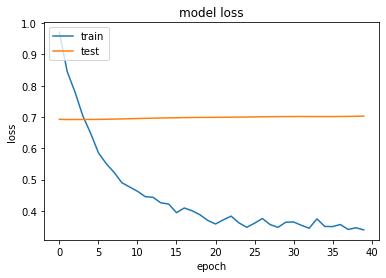

In [24]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 40
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
model.save_weights("resnet50.h5")
print("Saved model to disk")

0.5
Saved model to disk


In [26]:
del model
K.clear_session()

Epoch 1/40
3/3 [==============================] - 174s 54s/step - loss: 0.6932 - accuracy: 0.5312 - val_loss: 0.6929 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 2/40
3/3 [==============================] - 165s 51s/step - loss: 0.6929 - accuracy: 0.8687 - val_loss: 0.6926 - val_accuracy: 0.7750 - lr: 1.0000e-05
Epoch 3/40
3/3 [==============================] - 168s 53s/step - loss: 0.6927 - accuracy: 0.5938 - val_loss: 0.6922 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 4/40
3/3 [==============================] - 166s 52s/step - loss: 0.6922 - accuracy: 0.5063 - val_loss: 0.6916 - val_accuracy: 0.5250 - lr: 1.0000e-05
Epoch 5/40
3/3 [==============================] - 169s 54s/step - loss: 0.6915 - accuracy: 0.5813 - val_loss: 0.6905 - val_accuracy: 0.6250 - lr: 1.0000e-05
Epoch 6/40
3/3 [==============================] - 140s 39s/step - loss: 0.6903 - accuracy: 0.6562 - val_loss: 0.6884 - val_accuracy: 0.9500 - lr: 1.0000e-05
Epoch 7/40
3/3 [==============================] - 105s 32s

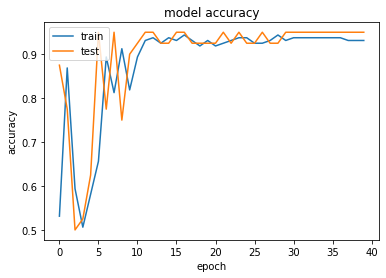

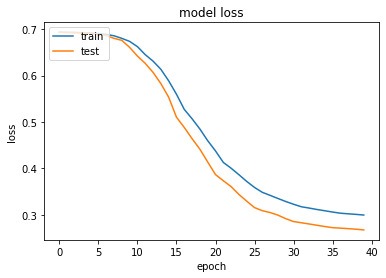

In [27]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np


input_shape = (224,224,3)
lr = 1e-5
epochs = 40
batch_size = 64

model = VGG16(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

vgg16_json = model.to_json()

with open("vgg16.json", "w") as json_file:
    json_file.write(vgg16_json)
    
model.save_weights("vgg16.h5")
print("Saved model to disk")

del model
K.clear_session()

0.805
Saved model to disk


Epoch 1/40
3/3 [==============================] - 524s 128s/step - loss: 0.6872 - accuracy: 0.5562 - val_loss: 0.6932 - val_accuracy: 0.4750 - lr: 1.0000e-05
Epoch 2/40
3/3 [==============================] - 354s 97s/step - loss: 0.6438 - accuracy: 0.8250 - val_loss: 0.6932 - val_accuracy: 0.4750 - lr: 1.0000e-05
Epoch 3/40
3/3 [==============================] - 397s 103s/step - loss: 0.6011 - accuracy: 0.9250 - val_loss: 0.6932 - val_accuracy: 0.4750 - lr: 1.0000e-05
Epoch 4/40
3/3 [==============================] - 339s 84s/step - loss: 0.5638 - accuracy: 0.9250 - val_loss: 0.6932 - val_accuracy: 0.4750 - lr: 1.0000e-05
Epoch 5/40
3/3 [==============================] - 354s 90s/step - loss: 0.5278 - accuracy: 0.9375 - val_loss: 0.6932 - val_accuracy: 0.4750 - lr: 1.0000e-05
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.9312  
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
3/3 [==============================] - 366s

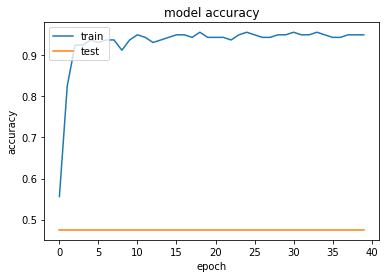

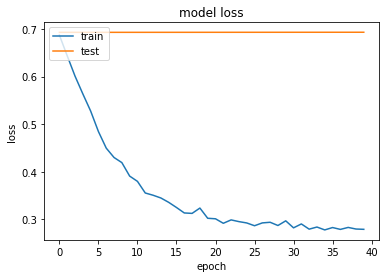

In [29]:
from keras.applications.xception import Xception


input_shape = (224,224,3)
lr = 1e-5
epochs = 40
batch_size = 64

model = Xception(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

xception_json = model.to_json()

with open("xception.json", "w") as json_file:
    json_file.write(xception_json)
    
model.save_weights("xception.h5")
print("Saved model to disk")

del model
K.clear_session()

0.5
Saved model to disk
